In [1]:
import iris
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import datetime
import numpy as np
import iris.coords as icoords
import iris.coord_categorisation
import iris.quickplot as qplt 
import numpy.ma as ma
from iris.util import broadcast_to_shape

In [2]:
#defining a function to calculate global average T
def area_average(cube):
    
    if cube.coord('latitude').bounds is None:
        cube.coord('latitude').guess_bounds()
        cube.coord('longitude').guess_bounds()
    
    grid_areas = iris.analysis.cartography.area_weights(cube)
    average = cube.collapsed(['latitude','longitude'],iris.analysis.MEAN, weights=grid_areas)
    
    return average

In [3]:
#defining function to merge cube list into single large cube
def time_reset(cubes): 
    
    time_coord = cubes[0].coord('time')
    n=1
    for cube in cubes:
        cube.remove_coord('time')
        cube.add_dim_coord(time_coord,0)
        cube.remove_coord('forecast_reference_time')
        cube.remove_coord('forecast_period')
        n+=1
    
    return 

In [4]:
#defining function to merge cube list into single large cube
def time_reset_again(cubes): 
    
    time_coord = cubes[0].coord('time')
    n=1
    for cube in cubes:
        cube.remove_coord('time')
        cube.add_dim_coord(time_coord,0)
        n+=1
    
    return 

In [5]:
#defining function to merge cube list into single large cube
def merge_cubes(cubes): 
    
    """
    Merge all ensemble members into one cube
    All cubes given the same time coordinate
    """

    big_cube = iris.cube.CubeList()
    n=1
    for cube in cubes:
        ensemble_coord = icoords.AuxCoord(n, standard_name='realization')
        new_cube = cube.copy()
        new_cube.add_aux_coord(ensemble_coord)
        big_cube.append(new_cube)
        n+=1
    
    return big_cube.merge_cube()

In [6]:
#defining function to merge cube list into single large cube
def merge_cubes_again(cubes): 
    
    """
    Merge all ensemble members into one cube
    All cubes given the same time coordinate
    """

    big_cube = iris.cube.CubeList()
    for cube in cubes:
        new_cube = cube.copy()
        big_cube.append(new_cube)
    
    return big_cube.merge_cube()

In [7]:
dir_in_coupled = '/shared/netscratch/lrm49/Laura/'
coupled_cntl = ['u-bu651','u-bv666','u-bv668','u-bv669','u-bv670','u-bv674','u-bv676','u-bv677','u-bv678']
coupled_jul_east = ['u-bv020','u-bw758','u-bw761','u-bw762','u-bw764','u-bw765'] 
coupled_jul_west = ['u-bw763','u-bw766','u-bw767'] 
coupled_jan_east = ['u-ca322', 'u-ca323', 'u-ca324', 'u-ca325', 'u-ca328']
coupled_jan_west = ['u-ca326', 'u-ca327', 'u-ca330','u-ca331']

In [8]:
nino_constraint = iris.Constraint(longitude=lambda v: -170+360 <= v <= -120+360,latitude=lambda v: -5 <= v <= 5)

In [9]:
sat_east = iris.cube.CubeList()
for job_id in coupled_jul_east:

    dynamic_cube = iris.load(dir_in_coupled+'Samalas_July/'+job_id+'_dynamics_vars.nc')
    sst_cube = dynamic_cube.extract('surface_temperature')[0]
    time_limit = sst_cube[6:120]
    enso = time_limit.extract(nino_constraint)
    area_av = area_average(enso)

    sat_east.append(area_av)
    
for job_id in coupled_jan_east:
    
    dynamic_cube = iris.load(dir_in_coupled+'Samalas_Jan/'+job_id+'_dynamics_vars.nc')
    sst_cube = dynamic_cube.extract('surface_temperature')[0]
    time_limit = sst_cube[0:114]
    enso = time_limit.extract(nino_constraint)
    area_av = area_average(enso)

    sat_east.append(area_av)

In [10]:
sat_west = iris.cube.CubeList()
for job_id in coupled_jul_west:

    dynamic_cube = iris.load(dir_in_coupled+'Samalas_July/'+job_id+'_dynamics_vars.nc')
    sst_cube = dynamic_cube.extract('surface_temperature')[0]
    time_limit = sst_cube[6:120]
    enso = time_limit.extract(nino_constraint)
    area_av = area_average(enso)

    sat_west.append(area_av)
    
for job_id in coupled_jan_west:
    
    dynamic_cube = iris.load(dir_in_coupled+'Samalas_Jan/'+job_id+'_dynamics_vars.nc')
    sst_cube = dynamic_cube.extract('surface_temperature')[0]
    time_limit = sst_cube[0:114]
    enso = time_limit.extract(nino_constraint)
    area_av = area_average(enso)

    sat_west.append(area_av)

In [11]:
## CONTROL ##
control = iris.cube.CubeList()
for job_id_2 in coupled_cntl:

    control_cube = iris.load(dir_in_coupled+'Control/'+job_id_2+'_dynamics_vars.nc')
    sst_control = control_cube.extract('surface_temperature')[0]
    enso = sst_control.extract(nino_constraint)
    area_av = area_average(enso)

    control.append(area_av)

In [12]:
time_reset(sat_east)
time_reset(sat_west)
time_reset(control)

In [13]:
sat_merged_east = merge_cubes(sat_east)
sat_merged_west = merge_cubes(sat_west)
one_big_control = merge_cubes(control)

In [14]:
#Creating control ensemble average
mean_control = one_big_control.collapsed('realization',iris.analysis.MEAN)

/home/lw602/.conda/envs/py27iris/lib/python2.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'realization'.
  warnings.warn(msg.format(self.name()))


In [15]:
#Creating 10 year climatology
import iris.coord_categorisation
iris.coord_categorisation.add_month(mean_control,'time',name='month')
climatology_all_controls = mean_control.aggregated_by('month',iris.analysis.MEAN) 
climatology_long = np.tile(climatology_all_controls.data, 10)
climatology_short_1 = climatology_long[6:120]
climatology_short_2 = climatology_long[0:114]


In [16]:
anomally = one_big_control - climatology_long

In [17]:
anom_east = iris.cube.CubeList()

for i in range(0,6):
    anomally_east = sat_merged_east[i] - climatology_short_1
    anom_east.append(anomally_east)

for i in range(6,11):
    anomally_east = sat_merged_east[i] - climatology_short_2
    anom_east.append(anomally_east)

In [18]:
anom_west = iris.cube.CubeList()

for i in range(0,3):
    anomally_west = sat_merged_west[i] - climatology_short_1
    anom_west.append(anomally_west)

for i in range(3,7):
    anomally_west = sat_merged_west[i] - climatology_short_2
    anom_west.append(anomally_west)

In [19]:
anom_east_full = merge_cubes_again(anom_east)
anom_west_full = merge_cubes_again(anom_west)

In [20]:
pert_east = iris.cube.CubeList()
a = anom_east_full[0] - anomally[0][6:120].data#
b = anom_east_full[1] - anomally[1][6:120].data
c = anom_east_full[2] - anomally[2][6:120].data
d = anom_east_full[3] - anomally[3][6:120].data#
e = anom_east_full[4] - anomally[5][6:120].data
f = anom_east_full[5] - anomally[6][6:120].data#
g = anom_east_full[6] - anomally[0][0:114].data
h = anom_east_full[7] - anomally[1][0:114].data
i = anom_east_full[8] - anomally[2][0:114].data
j = anom_east_full[9] - anomally[3][0:114].data
k = anom_east_full[10] - anomally[6][0:114].data
pert_east.append(a)
pert_east.append(b)
pert_east.append(c)
pert_east.append(d)
pert_east.append(e)
pert_east.append(f)
pert_east.append(g)
pert_east.append(h)
pert_east.append(i)
pert_east.append(j)
pert_east.append(k)


pert_west = iris.cube.CubeList()
a = anom_west_full[0] - anomally[4][6:120].data#
b = anom_west_full[1] - anomally[7][6:120].data
c = anom_west_full[2] - anomally[8][6:120].data
d = anom_west_full[3] - anomally[4][0:114].data
e = anom_west_full[4] - anomally[5][0:114].data
f = anom_west_full[5] - anomally[7][0:114].data
g = anom_west_full[6] - anomally[8][0:114].data
pert_west.append(a)
pert_west.append(b)
pert_west.append(c)
pert_west.append(d)
pert_west.append(e)
pert_west.append(f)
pert_west.append(g)



In [21]:
time_reset_again(pert_west)
time_reset_again(pert_east)

In [22]:
pert_east_full = merge_cubes_again(pert_east)
pert_west_full = merge_cubes_again(pert_west)


In [23]:
#Taking ensemble mean anomalies 
mean_anomally_east = anom_east_full.collapsed('realization',iris.analysis.MEAN)
mean_anomally_west = anom_west_full.collapsed('realization',iris.analysis.MEAN)

In [24]:
#Taking ensemble mean anomaly perturbations 
mean_pert_east = pert_east_full.collapsed('realization',iris.analysis.MEAN)
mean_pert_west = pert_west_full.collapsed('realization',iris.analysis.MEAN)

In [25]:
time = range(0,114)

zero = []

for i in range(0,114):
    i = 0
    zero.append(i)

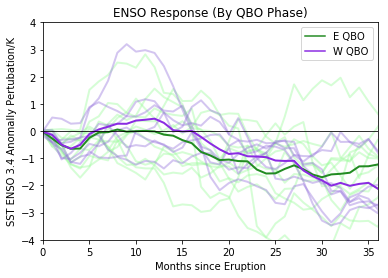

In [26]:
from matplotlib.lines import Line2D

for cube in pert_east_full.slices_over('realization'): # loop through ensemble members
    
    plt.plot(time, cube.data, color='palegreen', alpha = 0.4, lw=2)#plotting mean

for cube in pert_west_full.slices_over('realization'): # loop through ensemble members
    
    plt.plot(time, cube.data, color='mediumpurple', alpha = 0.4, lw=2)#plotting mean
    
plt.plot(time, mean_pert_east.data, color='forestgreen',lw=2)
plt.plot(time, mean_pert_west.data, color='blueviolet',lw=2)

plt.plot(time, zero, color='black', lw = 1, linestyle='-', alpha = 0.8)

plt.xlabel('Months since Eruption')
plt.ylabel('SST ENSO 3.4 Anomally Pertubation/K')
plt.xlim(time[0],time[36])
plt.ylim(-4,4)
july_line = Line2D([0], [0], label='E QBO', color='forestgreen')
jan_line = Line2D([0], [0], label='W QBO', color='blueviolet')
plt.legend(handles=[july_line, jan_line])
plt.title('ENSO Response (By QBO Phase)')

plt.savefig('ENSO_pertubation_by_QBO.pdf')

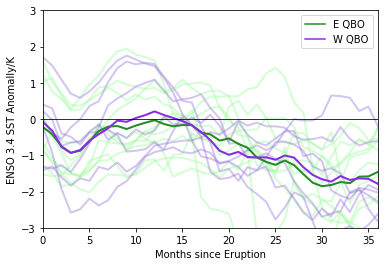

In [27]:
from matplotlib.lines import Line2D

for cube in anom_east_full.slices_over('realization'): # loop through ensemble members
    
    plt.plot(time, cube.data, color='palegreen', alpha = 0.4, lw=2)#plotting mean

for cube in anom_west_full.slices_over('realization'): # loop through ensemble members
    
    plt.plot(time, cube.data, color='mediumpurple', alpha = 0.4, lw=2)#plotting mean
    
plt.plot(time, mean_anomally_east.data, color='forestgreen',lw=2)
plt.plot(time, mean_anomally_west.data, color='blueviolet',lw=2)

plt.plot(time, zero, color='black', lw = 1, linestyle='-', alpha = 0.8)

plt.xlabel('Months since Eruption')
plt.ylabel('ENSO 3.4 SST Anomally/K')
plt.xlim(time[0],time[36])
plt.ylim(-3,3)
july_line = Line2D([0], [0], label='E QBO', color='forestgreen')
jan_line = Line2D([0], [0], label='W QBO', color='blueviolet')
plt.legend(handles=[july_line, jan_line])
plt.savefig('ENSO_pertubation_by_QBO_ABSOLUTE.pdf')